### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
from matplotlib import rc
from sklearn.model_selection import train_test_split

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.impute import SimpleImputer

# For better viewing of datasets
pd.set_option('display.max_columns', None)

### Reading in the data

In [4]:
#Read in the data
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [5]:
train.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,invigilator,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,invigilator_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,High school (10th grade),3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School (12th grade),4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,High school (10th grade),1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,High school (10th grade),3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School (12th grade),1,42.0,2,N,4.0,1


In [6]:
train.shape

(73147, 16)

In [7]:
test.shape

(31349, 15)

In [8]:
train.columns

Index(['id', 'program_id', 'program_type', 'program_duration', 'test_id',
       'test_type', 'difficulty_level', 'invigilator', 'gender', 'education',
       'city_tier', 'age', 'total_programs_enrolled', 'is_handicapped',
       'invigilator_engagement_rating', 'is_pass'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73147 entries, 0 to 73146
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             73147 non-null  object 
 1   program_id                     73147 non-null  object 
 2   program_type                   73147 non-null  object 
 3   program_duration               73147 non-null  int64  
 4   test_id                        73147 non-null  int64  
 5   test_type                      73147 non-null  object 
 6   difficulty_level               73147 non-null  object 
 7   invigilator                    73147 non-null  int64  
 8   gender                         73147 non-null  object 
 9   education                      73147 non-null  object 
 10  city_tier                      73147 non-null  int64  
 11  age                            45418 non-null  float64
 12  total_programs_enrolled        73147 non-null 

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31349 entries, 0 to 31348
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             31349 non-null  object 
 1   program_id                     31349 non-null  object 
 2   program_type                   31349 non-null  object 
 3   program_duration               31349 non-null  int64  
 4   test_id                        31349 non-null  int64  
 5   test_type                      31349 non-null  object 
 6   difficulty_level               31349 non-null  object 
 7   invigilator                    31349 non-null  int64  
 8   gender                         31349 non-null  object 
 9   education                      31349 non-null  object 
 10  city_tier                      31349 non-null  int64  
 11  age                            19558 non-null  float64
 12  total_programs_enrolled        31349 non-null 

From the above we can see that there are missing values in age column and invigilator_engagement_rating column. The former we can potentially impute based on program average age and latter can be filled by:

1) If we already have that invigilator's rating in the data   
2) Or Average invigilator_enagagement_rating 

In [12]:
train['is_pass'].value_counts()

1    50867
0    22280
Name: is_pass, dtype: int64

So majority class is the pass ones and we have class imbalance here. However, as do not have a small sample size we can just use stratified sampling and AUC-ROC as the eval metric with 5-fold CV

### Exploratory Data Analysis

Let's start by looking at how many discrete categories we have in each categorical column

In [31]:
# All categorical cols excluding ID
cat_cols = train.iloc[:,1:].select_dtypes(include=['object']).columns
num_cols = train.iloc[:1:].select_dtypes(exclude=['object']).columns[:-1]
for col in cat_cols:
    print("Value counts for column - {}:\n".format(col))
    print(train[col].value_counts())

Value counts for column - program_id:

Y_1    6687
Y_3    6623
T_3    6248
Y_4    5009
T_4    4792
U_1    4748
V_4    4301
T_2    4266
Y_2    4241
V_3    3419
V_1    3409
T_1    3152
U_2    3073
Z_3    2659
Z_2    2097
V_2    1896
Z_1    1873
X_1    1349
X_3    1205
X_2     774
S_2     682
S_1     644
Name: program_id, dtype: int64
Value counts for column - program_type:

Y    22560
T    18458
V    13025
U     7821
Z     6629
X     3328
S     1326
Name: program_type, dtype: int64
Value counts for column - test_type:

offline    43543
online     29604
Name: test_type, dtype: int64
Value counts for column - difficulty_level:

easy            40101
intermediate    20668
hard            10297
vary hard        2081
Name: difficulty_level, dtype: int64
Value counts for column - gender:

M    39043
F    34104
Name: gender, dtype: int64
Value counts for column - education:

High School (12th grade)    34371
High school (10th grade)    26169
Bachelor's                  11581
No qualification   

In [32]:
num_cols

Index(['program_duration', 'test_id', 'invigilator', 'city_tier', 'age',
       'total_programs_enrolled', 'invigilator_engagement_rating'],
      dtype='object')

Let's check which categorical variables are significant to our target variable using Chi-square test

In [34]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(train[cat_cols])
train_enc = oe.transform(train[cat_cols])

In [35]:
train_enc

array([[15.,  5.,  0., ...,  1.,  2.,  0.],
       [ 2.,  1.,  0., ...,  0.,  1.,  0.],
       [20.,  6.,  1., ...,  1.,  2.,  0.],
       ...,
       [16.,  5.,  1., ...,  1.,  2.,  0.],
       [10.,  3.,  0., ...,  1.,  1.,  0.],
       [18.,  5.,  1., ...,  0.,  1.,  0.]])

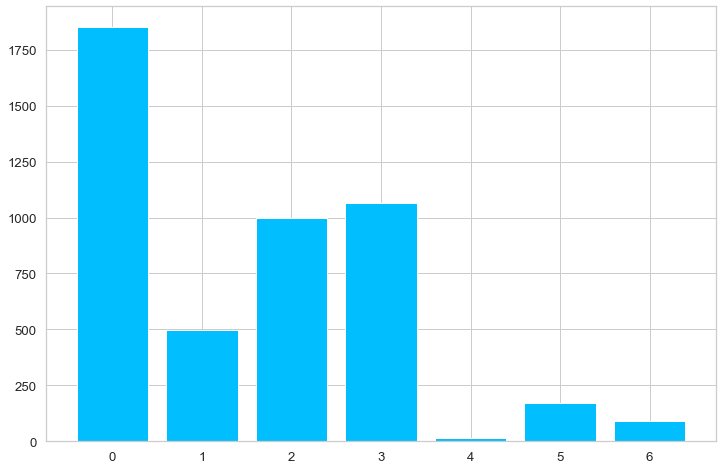

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def plot_cat_feat_importance(X_train, y_train):
    fs = SelectKBest(score_func = chi2, k = 'all')
    fs.fit(X_train, y_train)
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

plot_cat_feat_importance(train_enc,train.iloc[:,-1])

From this, it appears that the first four columns are highly important in prediction our target variable. Let's move forward with those only

In [45]:
cat_cols = cat_cols[:4]

### Handling missing values & Categorical data

In [64]:
from sklearn.preprocessing import StandardScaler
def prepare_inputs(data):
    ids = data.iloc[:,:1]
    X = data.iloc[:,1:]
    
    # Imputing missing values
    X['age'] = X.groupby('program_id').transform(lambda x: x.fillna(x.mean()))
    X['invigilator_engagement_rating'] = X.groupby('program_id').transform(lambda x: x.fillna(x.mean()))
    
    # Encode categorical columns
    encoded_cols = pd.get_dummies(X[cat_cols], prefix=cat_cols, drop_first=True)
    X = pd.concat([X[num_cols], encoded_cols], axis=1)
    
    # Standardize Numerical Values
    scaler = StandardScaler()
    X[num_cols] = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols)
    
    return (ids, X)

In [65]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.3, random_state=42)

In [66]:
X_train_enc = prepare_inputs(X_train)
X_cv_enc = prepare_inputs(X_cv)

In [67]:
X_test_enc = prepare_inputs(test.iloc[1:])

In [68]:
X_train_enc[1]

,program_duration,test_id,invigilator,city_tier,age,total_programs_enrolled,invigilator_engagement_rating,program_id_S_2,program_id_T_1,program_id_T_2,program_id_T_3,program_id_T_4,program_id_U_1,program_id_U_2,program_id_V_1,program_id_V_2,program_id_V_3,program_id_V_4,program_id_X_1,program_id_X_2,program_id_X_3,program_id_Y_1,program_id_Y_2,program_id_Y_3,program_id_Y_4,program_id_Z_1,program_id_Z_2,program_id_Z_3,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard
9877,0.836089,0.350554,-1.208246,-1.235364,0.836089,-0.467283,0.836089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
28983,0.400188,-0.195815,-1.085829,1.729348,0.400188,-0.467283,0.400188,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
64313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
7031,0.836089,-1.308066,0.336592,-1.235364,0.836089,-0.467283,0.836089,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
51018,1.126690,1.287187,1.200693,-1.235364,1.126690,1.142257,1.126690,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,-0.907516,-0.293381,-0.366912,0.741111,-0.907516,-0.467283,-0.907516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
6265,-1.198117,0.955463,0.805245,0.741111,-1.198117,1.142257,-1.198117,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
54886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
860,-1.198117,1.540858,0.478974,1.729348,-1.198117,-1.272053,-1.198117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [69]:
y_train

9877     1
28983    1
64313    1
7031     1
51018    1
        ..
37194    0
6265     0
54886    1
860      1
15795    0
Name: is_pass, Length: 51202, dtype: int64

In [88]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators = 5000,learning_rate = 0.1,  max_depth = 10)

model.fit(X_train_enc[1].values,y_train.values)

y_pred = model.predict(X_cv_enc[1].values)

y_test = model.predict(X_test_enc[1].values)

[09:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [89]:
model.feature_importances_

array([0.01792352, 0.01646985, 0.01706564, 0.01725225, 0.        ,
       0.01950117, 0.        , 0.01559795, 0.03596499, 0.01923834,
       0.02356306, 0.02665948, 0.02158852, 0.01907741, 0.02370316,
       0.01562415, 0.01906331, 0.07166345, 0.01149702, 0.01474268,
       0.01416598, 0.02113594, 0.02225546, 0.02273622, 0.02296292,
       0.01558196, 0.0182652 , 0.01988066, 0.02004905, 0.05125324,
       0.01806921, 0.14734384, 0.03312456, 0.02628733, 0.04106959,
       0.02488502, 0.01691062, 0.0578272 ], dtype=float32)

In [90]:
from sklearn.metrics import f1_score
cv_score = f1_score(y_cv, y_pred)
print(cv_score)

0.8051756426990523


In [102]:
X_test_enc[0]['is_pass'] = y_test

In [104]:
X_test_enc[0].to_csv('submission.csv',index=False)